#  Summary of what this capstone will, and may accomplish

* Scrape data from indeed, and return job postings
* properly format location, title, requirements (location done, 
* analyze what words and requirements occur the most
* Determine the quality of each job posting (how generic does it sound, and how common are the phrases that they are using) - this is important, but needs a bit of refinement
* Compare correlation between words used and position

Not required, but would be nice to implement
* add input to allow users to specifiy the cities to look at
* add a map to visualize how many postings there are in each city 

Web scraper script can be found at 
https://github.com/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Indeed%20Job%20Scraper.ipynb

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
# Import the dataframe
job_data = pd.read_csv('data/dc_indeed.csv', index_col=False)
job_data.drop(['Unnamed: 0'], 1, inplace=True)

In [3]:
# Let's check up on the size of our dataframe
job_data.shape

(1485, 7)

In [4]:
# Preview the data
job_data

,Title,Location,Company,Salary,Synopsis,Query,Metro
0,Data Analyst,"Washington, DC",Chenega Corporation,None,Perform data entry...,data+analyst,washington+dc
1,Program Data Analyst,"Arlington, VA",RGS,None,Organize and build...,data+analyst,washington+dc
2,Data Scientist - Human Capital Analytics,"Bethesda, MD 20816",Leidos,None,"Review, assess dat...",data+analyst,washington+dc
3,Intelligence Analyst with TS/SCI,"Washington, DC",Object CTalk Inc.,None,Strong analytical ...,data+analyst,washington+dc
4,Systems Analyst/Data Scientist,"Springfield, VA",Radiant Solutions,None,We build advanced ...,data+analyst,washington+dc
5,Aviation Data Systems Analyst,"Washington, DC",Concepts Beyond,None,The Analyst will p...,data+analyst,washington+dc
6,Health Interventions and Claims Data Analyst,"Washington, DC 20007 (Georgetown area)",Innovation Center for Biomedical Infor...,None,We are working on applying data sc...,data+analyst,washington+dc
7,Political Data Service Analyst,"Washington, DC 20005 (Logan Circle area)",Data Trust,None,The Data Services Analyst will be ...,data+analyst,washington+dc
8,Part Time/Full Time Administrative Assistant,"Washington, DC 20003 (Capitol Hill area)",General Dynamics Information Technology,\r\n $16 - $18 an hour,Support Program + Management analy...,data+analyst,washington+dc
9,Contractual Data Analyst (STASI),"Washington, DC 20431 (Foggy Bottom area)",International Monetary Fund,None,Contractual Data Analyst (STASI) (...,data+analyst,washington+dc


In [5]:
# Doing some data cleaning
for i, row in job_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (job_data['Location'][i]) = ' '.join((job_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (job_data['Synopsis'][i]) = (job_data['Synopsis'][i]).strip()

In [6]:
# Print number of unique categories for all non-numerical columns
job_data.select_dtypes(include=['object']).nunique()

Title       109
Location     30
Company     122
Salary       38
Synopsis    239
Query         3
Metro         1
dtype: int64

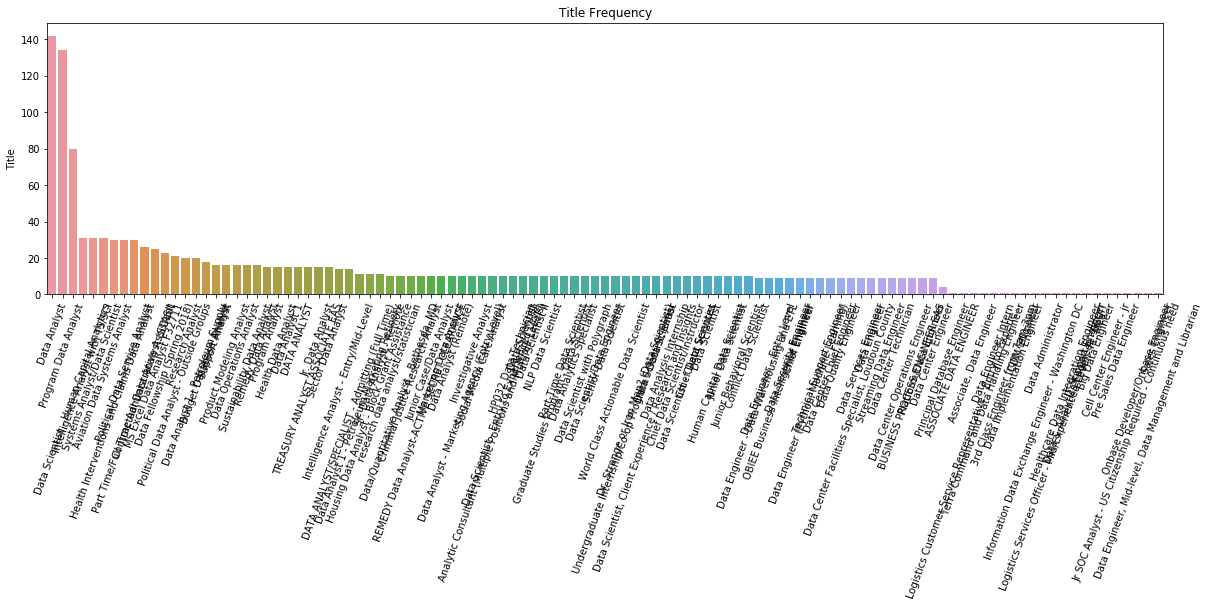

In [7]:
# View all job titles
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Title Frequency')

sns.barplot(job_data['Title'].unique(), job_data['Title'].value_counts(), data=job_data)

# Data Visualization

In [8]:
# Print out unique job titles and frequencies
job_data['Title'].value_counts()

Data Scientist                                                  142
Data Analyst                                                    134
Data Engineer                                                    80
Graduate Studies Program - Data Scientist                        31
Data Engineer – Entry Level                                      31
Data Scientist - Human Capital Analytics                         31
Data Engineer - Data Warehousing and ETL                         30
Data Analytics Specialist                                        30
Platform/Data Engineer                                           30
Data Scientist - Entry to Experienced Level                      26
Data Center Engineer                                             25
Sector Data Analyst                                              23
Data Scientist/Data Engineer                                     21
Criminal Justice Research Analyst                                20
DATA ANALYST                                    

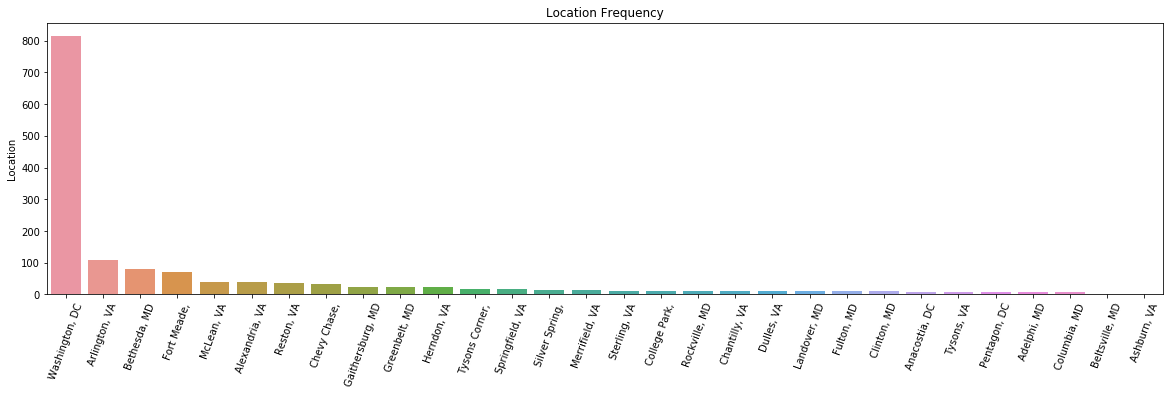

In [9]:
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Location Frequency')
x = job_data['Location'].value_counts().index.tolist()
y = job_data['Location'].value_counts()

sns.barplot(x, y, data=job_data)

In [10]:
location_data = job_data['Location'].value_counts()
location_data

Washington, DC      816
Arlington, VA       109
Bethesda, MD         79
Fort Meade,          71
McLean, VA           40
Alexandria, VA       38
Reston, VA           35
Chevy Chase,         32
Gaithersburg, MD     25
Greenbelt, MD        25
Herndon, VA          24
Tysons Corner,       16
Springfield, VA      16
Silver Spring,       15
Merrifield, VA       15
Sterling, VA         11
College Park,        11
Rockville, MD        10
Chantilly, VA        10
Dulles, VA           10
Landover, MD         10
Fulton, MD           10
Clinton, MD          10
Anacostia, DC         9
Tysons, VA            9
Pentagon, DC          9
Adelphi, MD           9
Columbia, MD          9
Beltsville, MD        1
Ashburn, VA           1
Name: Location, dtype: int64

In [11]:
job_data_original = job_data
job_data = job_data.replace(to_replace='None', value=np.nan).dropna()

In [12]:
# Cleaning up salary data
job_data = job_data[(~job_data.Salary.str.contains('an hour')) & (~job_data.Salary.str.contains('a month'))
                   & (~job_data.Salary.str.contains('a week')) & (~job_data.Salary.str.contains('a day'))]
job_data.Salary = job_data.Salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')

for i in job_data.Salary:
    if len(i.split('-')) != 1 and len(i.split('-')) != 2:
        print(i)

new_salaries = []
for i in job_data.Salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))
        
job_data.Salary = new_salaries

In [13]:
# View sample job descriptions
pd.options.display.max_colwidth = 200
job_data['Synopsis'].head(10)

14                           The Research Analyst must have:. The Research Analyst will be responsible for:. Mining data to identify trends and actionable insights....
15           Supporting the data validation team in resolving data issues. IMG-Crown has an opening for a Data Analyst I with excellent quantitative, analytical and...
24     The incumbent also provides advisory services to OCP managers and the procurement operations officer by interpreting data driven results that are compiled by...
26      Reviews data edits to ensure accuracy of the reported data, correcting and recording omissions, errors, or inconsistencies found, and communicating with the...
27    Develop, analyze, and evaluate data to create and maintain business intelligence frameworks Query data using SQL, performing complex operations on data within...
29     Responsibilities of the Data Analyst include:. The Data Analyst will be responsible for the analysis and data management for logistics systems within the

# Text Cleaning

In [14]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [15]:
# Remove annoying punctuation from the articles
job_data['Synopsis'] = job_data.Synopsis.map(lambda x: text_cleaner(str(x)))
job_data['Synopsis'].head()

14                           The Research Analyst must have:. The Research Analyst will be responsible for:. Mining data to identify trends and actionable insights....
15           Supporting the data validation team in resolving data issues. IMG-Crown has an opening for a Data Analyst I with excellent quantitative, analytical and...
24     The incumbent also provides advisory services to OCP managers and the procurement operations officer by interpreting data driven results that are compiled by...
26      Reviews data edits to ensure accuracy of the reported data, correcting and recording omissions, errors, or inconsistencies found, and communicating with the...
27    Develop, analyze, and evaluate data to create and maintain business intelligence frameworks Query data using SQL, performing complex operations on data within...
Name: Synopsis, dtype: object

# Natural Language Processing

In [16]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for summary in job_data['Synopsis']:
    summary = lemmatizer.lemmatize(summary)

In [17]:
# Identify predictor and target variables
X = job_data['Synopsis']
y = job_data['Title']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf vectorizer

In [18]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=5, 
                             max_features=150, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 150


### Spacy

In [19]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_train_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

In [20]:
# Combine tf-idf matrix and phrase count matrix
features = pd.concat([X_counter,X_normal], ignore_index=False, axis=1)
features.head()

,0,1,2,3,4,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.001479,0.002958,0.014791,0.001479,0.999884,0.279274,0.0,0.0,0.0,0.342203,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.005208,0.015623,0.006943,0.999840,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.235952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.002378,0.010701,0.003567,0.999934,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.012151,0.013887,0.001736,0.999828,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.215731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.012151,0.013887,0.001736,0.999828,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.215731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


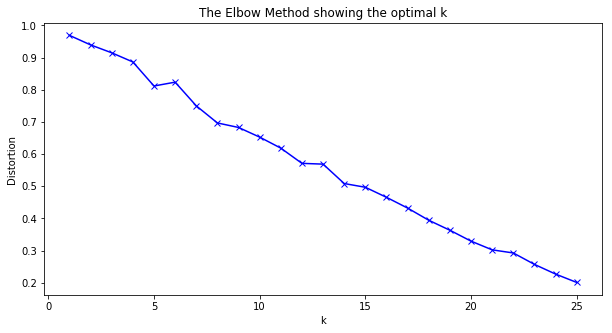

In [21]:
# Size of graph
plt.rcParams['figure.figsize'] = [10,5]

# k means determine k
distortions = []
K = range(1,job_data['Title'].nunique())
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features)
    kmeanModel.fit(features)
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [22]:
# Calulate predicted values
kmeans = KMeans(n_clusters=job_data['Query'].nunique(), init='k-means++', random_state=42, n_init=20)
y_pred1 = kmeans.fit_predict(features)

pd.crosstab(y_train, y_pred1)

col_0,0,1,2
Title,,,
BUSINESS PROCESS ENGINEER EAS,1,0,0
Chief Data Scientist,6,2,0
Data Administrator,7,0,0
Data Analyst,6,6,0
Data Analyst 1,9,0,0
Data Analyst 1 - Petroleum Marketing Refinery,6,0,0
Data Analyst 1 - Petroleum Supply,1,0,0
Data Engineer,16,8,0
Data Quality Engineer,1,0,0


In [23]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred1)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred1, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.06447893
Silhouette Score: 0.1405805


### Tf-idf Matrix

In [24]:
# Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(job_data['Synopsis'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=job_data['Query'].nunique()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [26]:
from sklearn.decomposition import NMF

# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [27]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
               LSA               NNMF
0        data 34.3        sector 4.49
0     analyst 14.3          data 2.66
0      sector 8.01        manage 2.25
0  management 7.63     operating 2.25
0   analytics 7.58         arise 2.25
0     ability 7.18     reporting 2.25
0      analyze 6.7      projects 2.25
0        team 6.43         chief 2.25
0     systems 6.09       special 2.25
0   engineers 5.88  additionally 2.22
Topic 1:
                LSA              NNMF
1  communicate 7.34      diverse 3.14
1      clearly 6.51   continuing 3.14
1   scientists 6.18  conclusions 3.14
1      diverse 5.98    sponsored 3.14
1   attendance 5.98    education 3.14
1      experts 5.98      experts 3.14
1    education 5.98     audience 3.14
1    sponsored 5.98   attendance 3.14
1   continuing 5.98       agency 3.11
1  conclusions 5.98      clearly 3.02
Topic 2:
                 LSA              NNMF
2        sector 6.76         data 7.16
2       special 3.38      systems 2.15
2     operating 3.38